In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.naive_bayes import GaussianNB
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn import tree

from sklearn import metrics
from sklearn.model_selection import train_test_split

from sktime.classification.shapelet_based import MrSEQLClassifier
from sktime.datasets import load_arrow_head, load_basic_motions

from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sktime.transformations.panel.rocket import Rocket
from sklearn.linear_model import RidgeClassifierCV

from sktime.datasets import load_arrow_head 

In [4]:
file = open("GWAS_Add.raw", "r")

In [5]:
lines = file.readlines()

In [6]:
len(lines)

90

In [7]:
columns = lines[0].strip("\n").split(" ")

In [8]:
columns = [n.split("_",1)[0] for n in columns]

In [9]:
df = pd.DataFrame(columns = columns)

In [10]:
data = []
for line in lines[1:]:
    newRow = line.strip("\n").split(" ")
    data.append(newRow)

In [11]:
df = pd.DataFrame(data, columns = columns)

In [12]:
dfAlleles = df.loc[:, "rs7594567":"rs749924"]
dfInfo = df.loc[:, :"PHENOTYPE"]
df = dfInfo.join(dfAlleles)

In [13]:
split = lines[2].replace("NA", "").replace("\n","").split()

In [14]:
split = split[5:]

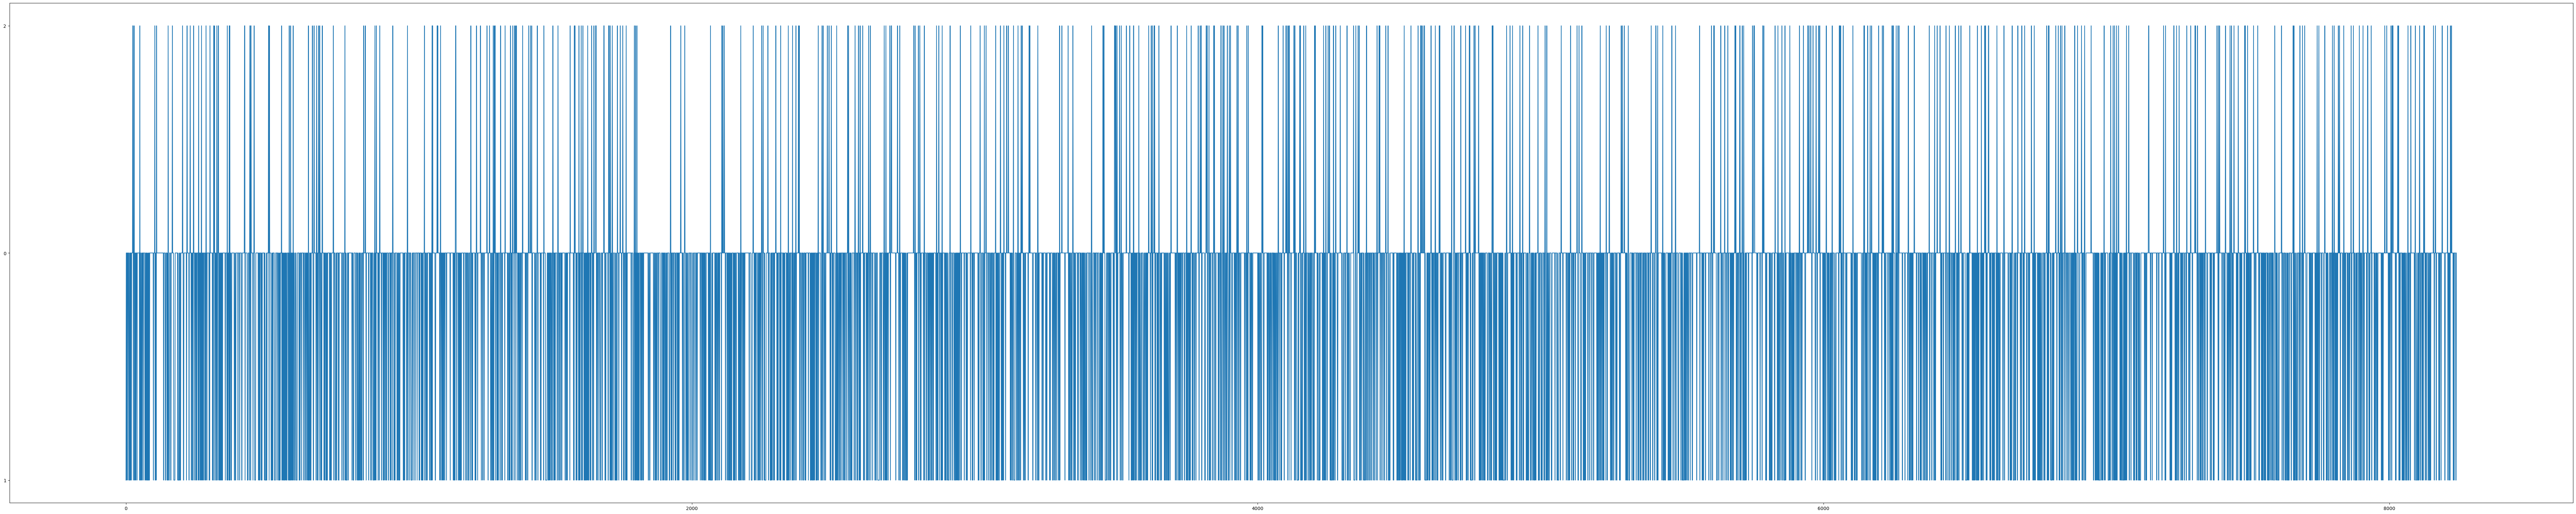

In [15]:
figure(figsize=(100, 20), dpi=100)
plt.plot(split[0::10])
plt.show()

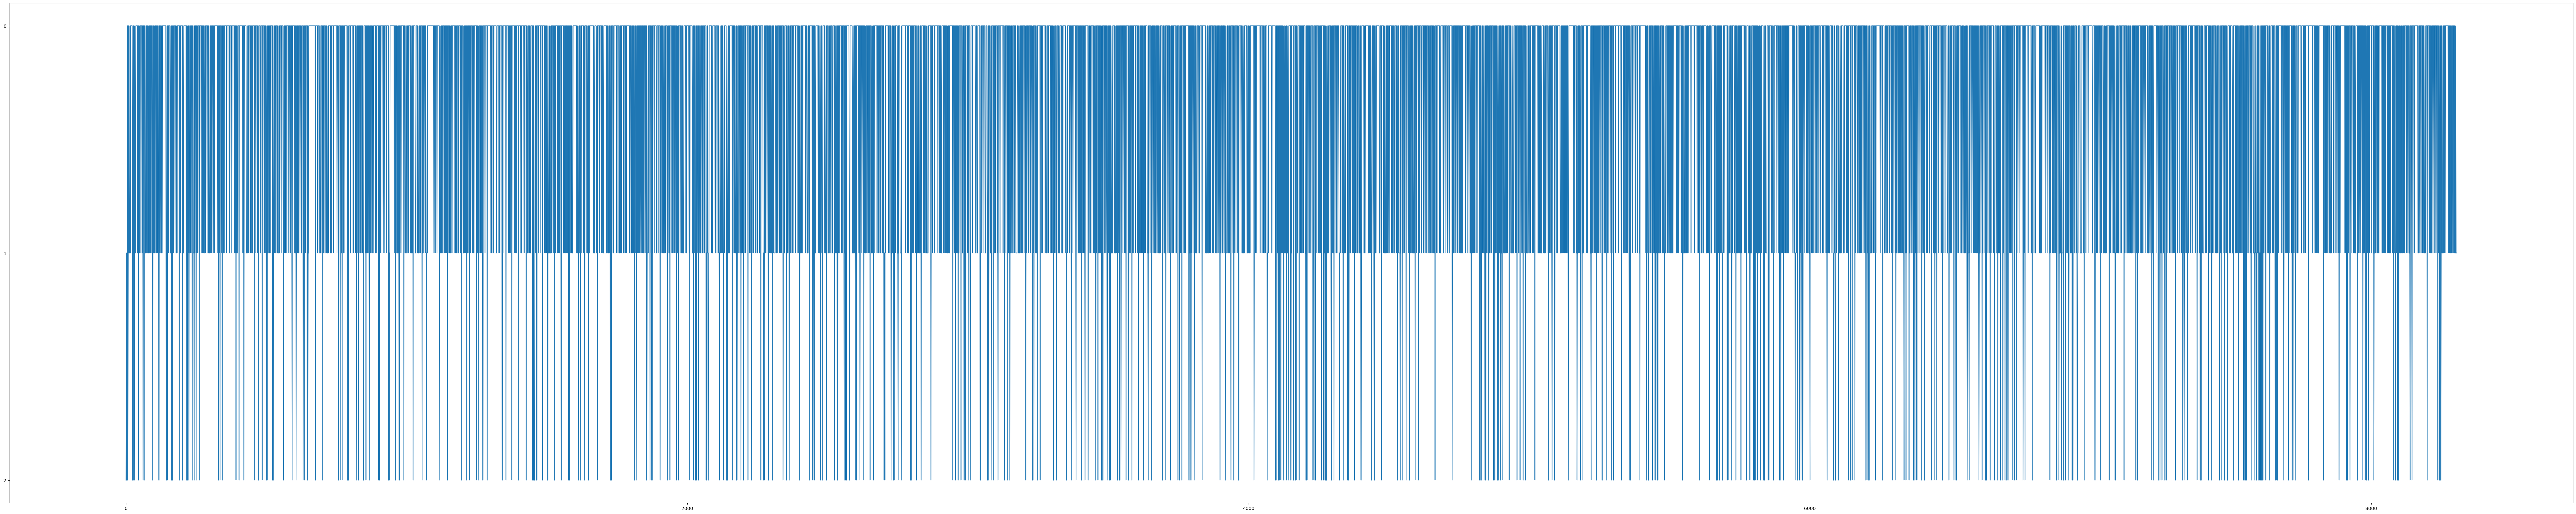

In [16]:
split = lines[3].replace("NA", "").replace("\n","").split()
split = split[5:]
figure(figsize=(100, 20), dpi=100)
plt.plot(split[0::10])
plt.show()

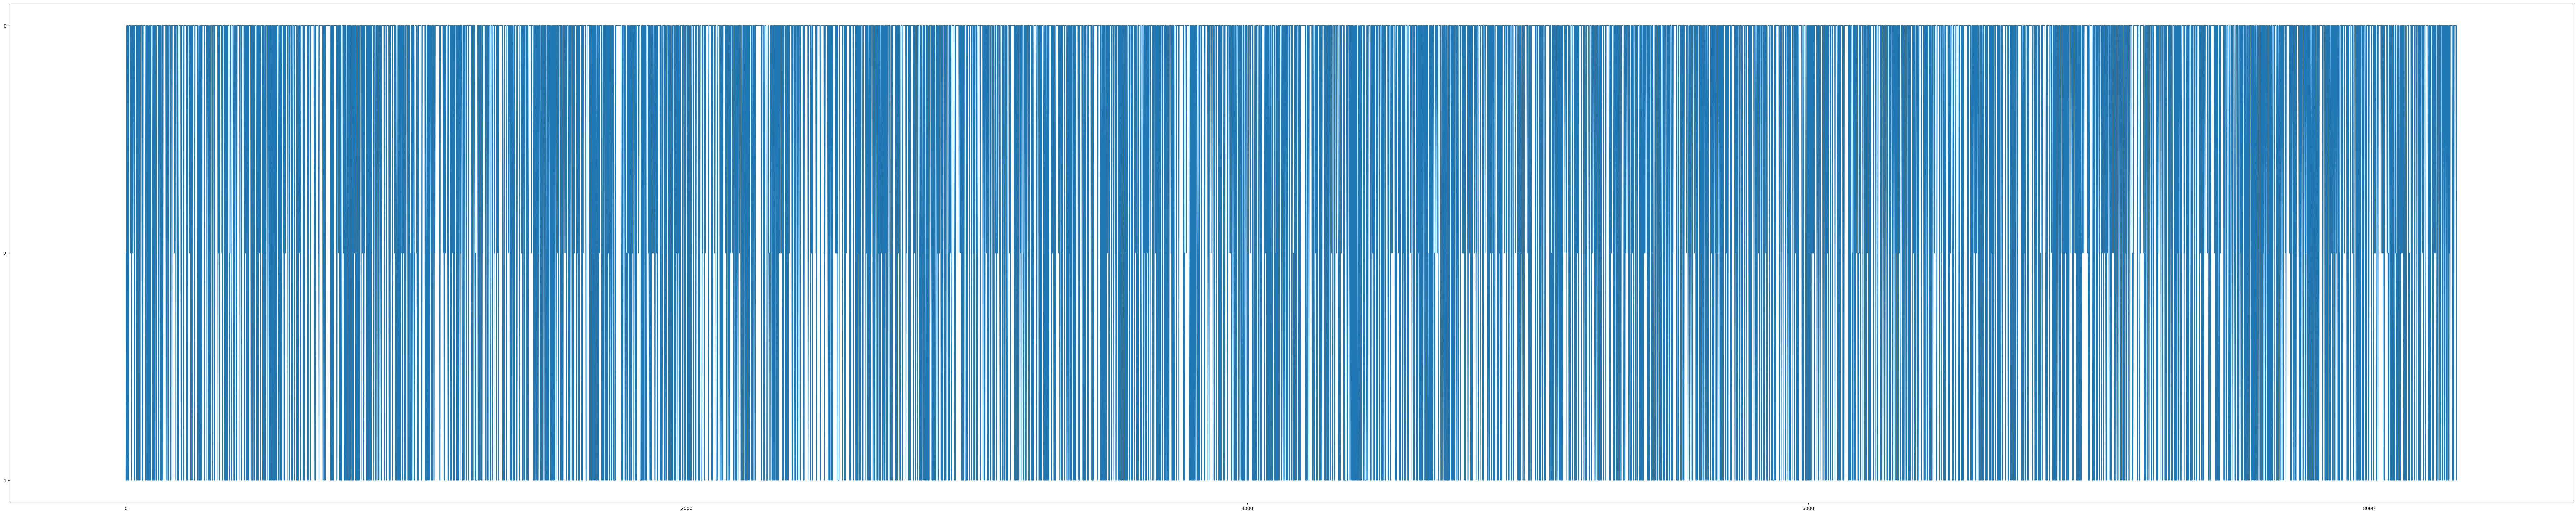

In [17]:
split = lines[4].replace("NA", "").replace("\n","").split()
split = split[5:]
figure(figsize=(100, 20), dpi=100)
plt.plot(split[0::10])
plt.show()

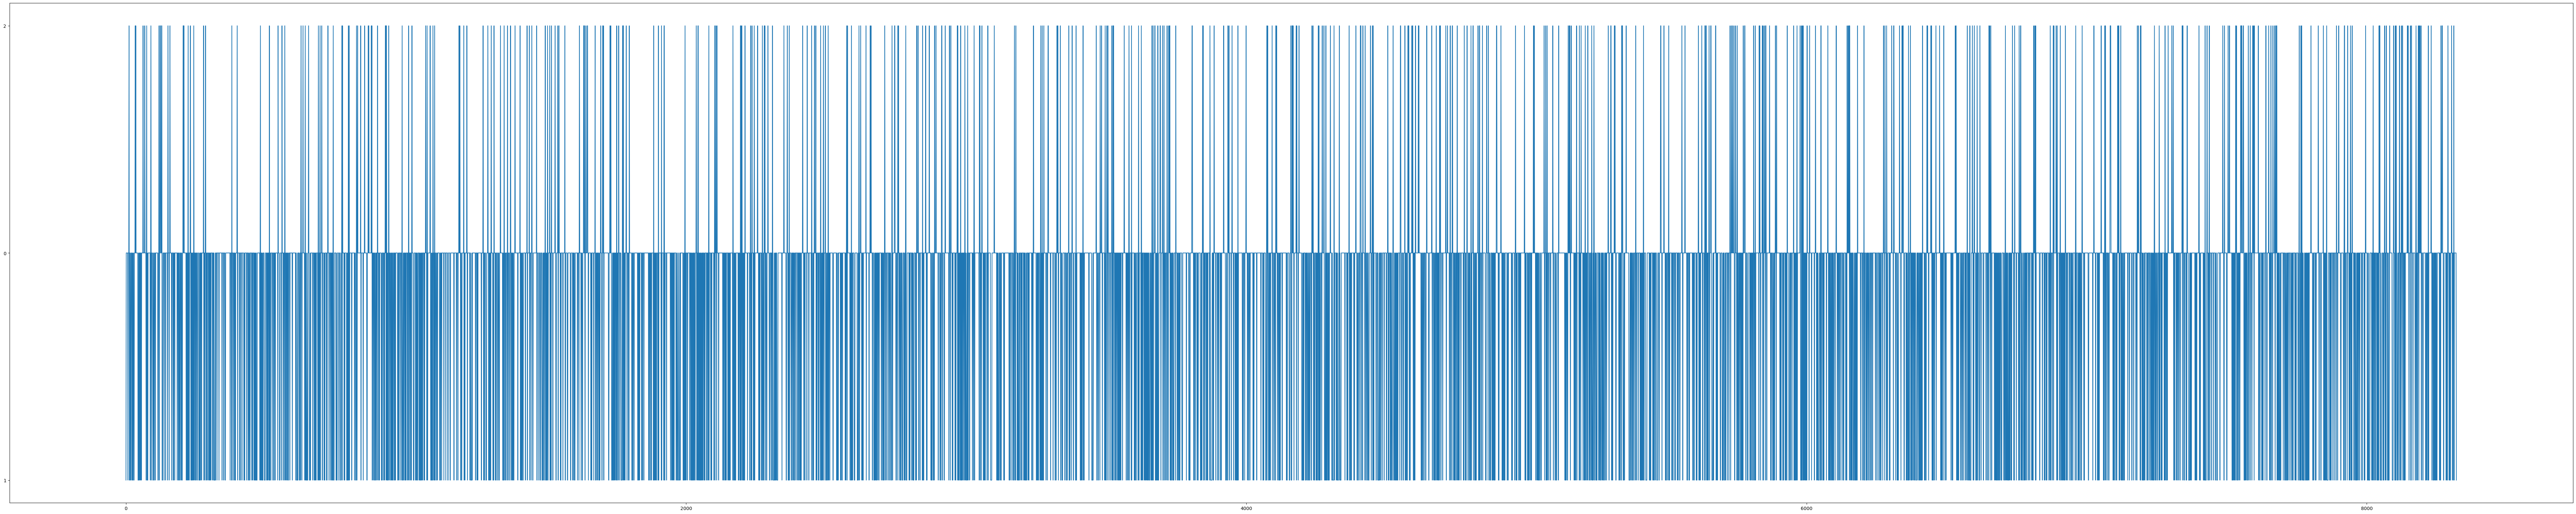

In [18]:
split = lines[5].replace("NA", "").replace("\n","").split()
split = split[5:]
figure(figsize=(100, 20), dpi=100)
plt.plot(split[0::10])
plt.show()

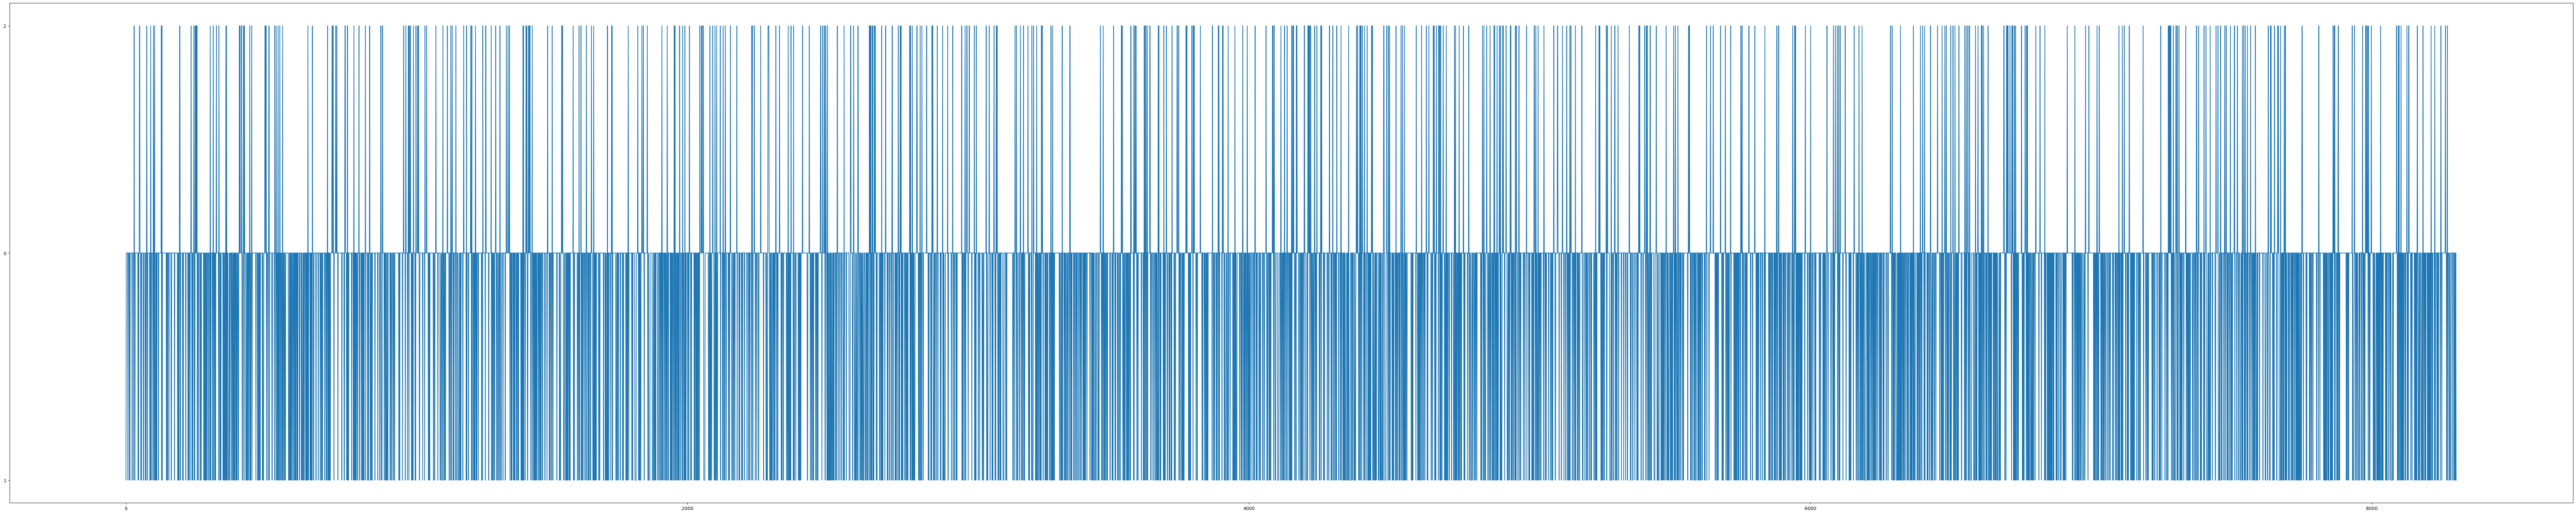

In [19]:
split = lines[85].replace("NA", "").replace("\n","").split()
split = split[5:]
figure(figsize=(100, 20), dpi=100)
plt.plot(split[0::10])
plt.show()

In [20]:
phenotype = df.pop("PHENOTYPE")

In [21]:
dfTest = df.drop(columns=["FID","IID","PAT","MAT","SEX"])

In [22]:
dfTest = dfTest.replace({"NA":np.nan},regex=True)

In [23]:
imp=SimpleImputer(missing_values=np.NaN,strategy='most_frequent')
idf=pd.DataFrame(imp.fit_transform(dfTest))

In [27]:
X_train, X_test, y_train, y_test = train_test_split(idf, phenotype, train_size=0.6, random_state=1)

In [30]:
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=3)
dtc.fit(X_train, y_train)
y_predicted = dtc.predict(X_train)
print("Testing accuracy score: {}".format(accuracy_score(y_train, y_predicted)))
y_predicted = dtc.predict(X_test)
print("Training accuracy score: {}".format(accuracy_score(y_test, y_predicted)))

Testing accuracy score: 1.0
Training accuracy score: 0.6388888888888888


In [ ]:
#tree.plot_tree(dtc,feature_names=idf.columns)

In [31]:
knn_clf = KNeighborsClassifier() 
knn_clf.fit(X_train, y_train)
y_predicted = knn_clf.predict(X_train)
print("Testing accuracy score: {}".format(accuracy_score(y_train, y_predicted)))
y_predicted = knn_clf.predict(X_test)
print("Training accuracy score: {}".format(accuracy_score(y_test, y_predicted)))

Testing accuracy score: 0.8679245283018868
Training accuracy score: 0.5


In [32]:
knn_clf = KNeighborsClassifier(n_neighbors=1) 
knn_clf.fit(X_train, y_train)
y_predicted = knn_clf.predict(X_train)
print("Testing accuracy score: {}".format(accuracy_score(y_train, y_predicted)))
y_predicted = knn_clf.predict(X_test)
print("Training accuracy score: {}".format(accuracy_score(y_test, y_predicted)))

Testing accuracy score: 1.0
Training accuracy score: 0.4444444444444444


In [33]:
idf = idf.apply(pd.to_numeric)

In [34]:
idfSeries = from_2d_array_to_nested(idf)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(idfSeries, phenotype, train_size=0.6, random_state=1)

In [36]:
y_train = y_train.values
y_test = y_test.values

In [37]:
X_train = X_train.reset_index()
X_train = X_train.drop(columns=['index'])

X_test = X_test.reset_index()
X_test = X_test.drop(columns=['index'])

In [38]:
rocket = Rocket()  # by default, ROCKET uses 10,000 kernels
rocket.fit(X_train)
X_train_transform = rocket.transform(X_train)

In [39]:
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
classifier.fit(X_train_transform, y_train)

C:\Users\emjcu\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                  normalize=True)

In [40]:
X_test_transform = rocket.transform(X_test)

In [41]:
classifier.score(X_test_transform, y_test)

0.5833333333333334

In [42]:
# Create mrseql object
# use sax by default
ms = MrSEQLClassifier(seql_mode="clf")
# use sfa representations
# ms = MrSEQLClassifier(seql_mode='fs', symrep=['sfa'])
# use sax and sfa representations
# ms = MrSEQLClassifier(seql_mode='fs', symrep=['sax', 'sfa'])

# fit training data
ms.fit(X_train, y_train)

# prediction
predicted = ms.predict(X_test)

# Classification accuracy
print("Accuracy with mr-seql: %2.3f" % metrics.accuracy_score(y_test, predicted))

Accuracy with mr-seql: 0.556
